## 【検証】Driverless AIのスコアリング機能を目的関数とした、GPyOptによるベイズ最適化
- あるDriverless AIの学習済みモデルにおいて、ターゲット変数yを最小化/最大化する、特徴量Xを計算したい

[2021/6/20] App実装検証用に修正  
[2021/6/28] GPyOpt引数変更  
[2021/8/18] カテゴリカル変数テスト

In [1]:
from GPyOpt.methods import BayesianOptimization
import os
import driverlessai
import pandas as pd
import numpy as np

### 学習データ
データはDriverless AIへアップロード済みだが、データ理解のため

In [2]:
data_name = os.path.join(os.environ['HOME'], 'Documents/Sample_Data/Boston_Housing/BostonHousing.csv')
df_tmp = pd.read_csv(data_name)
print(df_tmp.shape)
df_tmp.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
df_tmp.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


ターゲット変数：MEDV  
特徴量：MEDV以外の13変数

In [6]:
data_name = os.path.join(os.environ['HOME'], 'Documents/Sample_Data/UCI_CreditCard/UCI_Credit_Card2.csv')
df_tmp = pd.read_csv(data_name)
print(df_tmp.shape)
df_tmp.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
0,1,20000,M,university,married,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,M,university,single,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,M,university,single,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,M,university,married,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,F,university,married,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
df_tmp.describe()

,ID,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


ターゲット変数：LIMIT_BAL  
特徴量：SEX, EDUCATION, BILL_AMT1, BILL_AMT2, BILL_AMT3, BILL_AMT4, BILL_AMT5, BILL_AMT6

### Driverless AIへの接続

In [8]:
import json
with open('../idpass.json') as f:
    idpass = json.load(f)

In [11]:
# Driverless AIサーバーへの接続
dai = driverlessai.Client(address='http://ec2-3-82-104-25.compute-1.amazonaws.com', username=idpass['id'], password=idpass['pass1930'])
dai

<class 'driverlessai._core.Client'> http://ec2-3-82-104-25.compute-1.amazonaws.com

In [12]:
# 接続先Driverless AIのDatasets
dai.datasets.list()

    | Type    | Key                                  | Name
----+---------+--------------------------------------+----------------------------------------
  0 | Dataset | fe9493c8-ffaf-11eb-9071-0242ac110002 | UCI_Credit_Card2.csv
  1 | Dataset | c56363e8-f598-11eb-ba87-0242ac110002 | scsk_train.csv
  2 | Dataset | 14552b3c-e511-11eb-9db0-0242ac110002 | sample1.zip
  3 | Dataset | 53b3c30e-e50e-11eb-9db0-0242ac110002 | sample2.zip
  4 | Dataset | 0fa430c6-e433-11eb-bbce-0242ac110002 | tkn.amazon_reviews_JP_Books_AMPLE.csv
  5 | Dataset | ab4727f0-e432-11eb-bbce-0242ac110002 | amazon_reviews_JP_Books_1000SAMPLE.csv
  6 | Dataset | e307a4a4-dfa4-11eb-9633-0242ac110002 | TitanicData2.csv
  7 | Dataset | 0320c3ca-de23-11eb-a3ce-0242ac110002 | walmart_ts_6_fcst_grp_train.csv
  8 | Dataset | 031da9a6-de23-11eb-a3ce-0242ac110002 | walmart_ts_6_fcst_grp_test.csv
  9 | Dataset | c59d9454-d9f6-11eb-9ecf-0242ac110002 | uci_credit_card_TEST
 10 | Dataset | c59d67d6-d9f6-11eb-9ecf-0242ac110002 | uc

In [34]:
# 接続先Driverless AIのExperiments
dai.experiments.list()

    | Type       | Key                                  | Name
----+------------+--------------------------------------+-----------------
  0 | Experiment | 2f48f7fc-ffb5-11eb-9071-0242ac110002 | uci_cc_optTest2
  1 | Experiment | 3abf4f32-ffb0-11eb-9071-0242ac110002 | uci_cc_optTest
  2 | Experiment | a5a22a6e-f636-11eb-a9b3-0242ac110002 | dl1
  3 | Experiment | e9818b06-f598-11eb-ba87-0242ac110002 | scsk1
  4 | Experiment | e9f4e31a-ed9d-11eb-a164-0242ac110002 | 2.run_test
  5 | Experiment | d90cf272-ed9d-11eb-a164-0242ac110002 | 1.run_test
  6 | Experiment | ca7d4a7c-ed9d-11eb-a164-0242ac110002 | run_test
  7 | Experiment | e66d1e02-e5bd-11eb-8e3d-0242ac110002 | 1.boston2
  8 | Experiment | a087e4ce-e434-11eb-bbce-0242ac110002 | amazon1
  9 | Experiment | 91eeeac2-de2e-11eb-a3ce-0242ac110002 | walmart2
 10 | Experiment | 35126e7e-de23-11eb-a3ce-0242ac110002 | walmart1
 11 | Experiment | 273b8cec-da66-11eb-91ec-0242ac110002 | tucumibo
 12 | Experiment | 35f57a7c-da11-11eb-9ecf-0242ac

#### Experiment情報の取得

In [155]:
# 利用するExperimentの取得
# 目的関数となる予測モデル

experiment = dai.experiments.get(key='2f48f7fc-ffb5-11eb-9071-0242ac110002')
#experiment = dai.experiments.get(key='8f6c7d7c-d3ad-11eb-a4fa-0242ac110002')
type(experiment)

driverlessai._experiments.Experiment

In [156]:
# Experiment作成で利用したデータ
experiment.datasets

{'train_dataset': <class 'Dataset'> fe9493c8-ffaf-11eb-9071-0242ac110002 UCI_Credit_Card2.csv,
 'validation_dataset': None,
 'test_dataset': None}

In [157]:
# 学習データのKey
experiment.datasets['train_dataset'].key

'fe9493c8-ffaf-11eb-9071-0242ac110002'

In [158]:
# Experimentのターゲットカラム
target_col = experiment.settings['target_column']
target_col

'LIMIT_BAL'

In [159]:
# droped columns
try:
    drop_cols = experiment.settings['drop_columns']     # dropカラムがリストで返る
except KeyError:
    drop_cols = []     # dropしたカラムがない場合

drop_cols

['ID',
 'MARRIAGE',
 'AGE',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default_payment_next_month',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6']

In [160]:
# Experiment結果のサマリ
experiment.summary()

Status: Complete
Experiment: uci_cc_optTest2 (2f48f7fc-ffb5-11eb-9071-0242ac110002)
  Version: 1.9.3, 2021-08-17 23:47
  Settings: 2/2/7, seed=293466697, GPUs disabled
  Train data: UCI_Credit_Card2.csv (30000, 9)
  Validation data: N/A
  Test data: N/A
  Target column: LIMIT_BAL (regression, identity_noclip-transformed)
System specs: Docker/Linux, 31 GB, 8 CPU cores, 0/0 GPU
  Max memory usage: 0.505 GB, 0 GB GPU
Recipe: AutoDL (8 iterations, 2 individuals)
  Validation scheme: random, 1 internal holdout
  Feature engineering: 14 features scored (13 selected)
Timing: MOJO latency: 0.03500 millis (366.2kB)
  Data preparation: 4.21 secs
  Shift/Leakage detection: 0.74 secs
  Model and feature tuning: 23.31 secs (7 models trained)
  Feature evolution: 7.14 secs (2 of 22 models trained)
  Final pipeline training: 14.74 secs (9 models trained)
  Python / MOJO scorer building: 36.67 secs / 12.35 secs
Validation score: RMSE = 129745.5 (constant preds of 1.675e+05)
Validation score: RMSE = 10

#### 学習データ情報の取得

In [161]:
dataset = dai.datasets.get(key=experiment.datasets['train_dataset'].key)
dataset

<class 'Dataset'> fe9493c8-ffaf-11eb-9071-0242ac110002 UCI_Credit_Card2.csv

In [162]:
# 学習データのカラム
data_cols = dataset.columns
data_cols

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default_payment_next_month']

In [163]:
# Experiment作成に用いられた学習データのカラム

col_no_show = drop_cols.copy()
col_no_show.append(target_col)    # 学習データから除くカラム（ターゲット変数とdropped columns）

col_show = []
for col in data_cols:
    if col in col_no_show: 
        continue
    col_show.append(col)

col_show

['SEX',
 'EDUCATION',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6']

In [164]:
# Experiment作成に用いられた学習データの特徴量の最小値・最大値、データ型

min_list = []
max_list = []
type_list = []
for col in col_show:
    min_list.append(dataset.column_summaries()[col].min)
    max_list.append(dataset.column_summaries()[col].max)
    type_list.append(dataset.column_summaries()[col].data_type)

df_domain = pd.DataFrame({'col':col_show, 'min':min_list, 'max':max_list, 'data_type':type_list})
df_domain

,col,min,max,data_type
0,SEX,NaN,NaN,str
1,EDUCATION,NaN,NaN,str
2,BILL_AMT1,-165580.0,964511.0,int
3,BILL_AMT2,-69777.0,983931.0,int
4,BILL_AMT3,-157264.0,1664089.0,int
5,BILL_AMT4,-170000.0,891586.0,int
6,BILL_AMT5,-81334.0,927171.0,int
7,BILL_AMT6,-339603.0,961664.0,int


In [169]:
# カテゴリ型のカラム
cat_cols = df_domain[df_domain['data_type']=='str']['col'].values.tolist()
cat_cols

['SEX', 'EDUCATION']

In [170]:
# 特徴量のデータタイプ指定（'continuous', 'discrete'）
# ToDo: Appではカラム別にタイプ指定できるようにする

df_domain['type'] = 'continuous'
df_domain

,col,min,max,data_type,type
0,SEX,NaN,NaN,str,continuous
1,EDUCATION,NaN,NaN,str,continuous
2,BILL_AMT1,-165580.0,964511.0,int,continuous
3,BILL_AMT2,-69777.0,983931.0,int,continuous
4,BILL_AMT3,-157264.0,1664089.0,int,continuous
5,BILL_AMT4,-170000.0,891586.0,int,continuous
6,BILL_AMT5,-81334.0,927171.0,int,continuous
7,BILL_AMT6,-339603.0,961664.0,int,continuous


### GPyOptによるベイズ最適化

#### GPyOpt.methods.bayesian_optimization.BayesianOptimization
- Main class to initialize a Bayesian Optimization method
- https://gpyopt.readthedocs.io/en/latest/GPyOpt.methods.html#GPyOpt.methods.bayesian_optimization.BayesianOptimization

In [171]:
# 目的関数（スコアリング用関数）
# daimodel(x)が最小、もしくは最大となるxを計算したい

print(col_show)

def daimodel(x):
    ''' col_show（学習に使われたカラム名のリスト）が必要
    '''
    # スコアリングデータの作成
    df = pd.DataFrame(np.array([x[:,i] for i in range(len(col_show))]).reshape(1, len(col_show)), columns=col_show)
    #print(df)
    df.to_csv('tmp_pred.csv', index=False)
    # スコアリングデータをDAIへアップロード
    data_to_predict = dai.datasets.create(data='./tmp_pred.csv', data_source='upload', name='tmp_pred.csv', force=True)
    # 予測
    dai_predictions = experiment.predict(dataset=data_to_predict, include_columns=data_to_predict.columns)
    # スコアリングデータの削除
    data_to_predict.delete()
    # クライアント実行ディレクトリ上にダウンロード
    dai_predictions.download(dst_dir='', dst_file='tmp_res.csv', overwrite=True)    # tmp_res.csvとしてダウンロード
    df_res = pd.read_csv('tmp_res.csv')
    print('---------- Done ----------')
    # 予測結果（ターゲット変数のみ）をnp.arrayで返す
    return np.array(df_res[experiment.settings['target_column']])

['SEX', 'EDUCATION', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']


In [172]:
# 各変数の情報。domeinは入力の定義域（学習データの[最小値,最大値]と設定）
bounds = [{'name':row['col'], 'type':row['type'], 'domain':(row['min'],row['max'])} for _, row in df_domain.iterrows()]
bounds

[{'name': 'SEX', 'type': 'continuous', 'domain': (nan, nan)},
 {'name': 'EDUCATION', 'type': 'continuous', 'domain': (nan, nan)},
 {'name': 'BILL_AMT1', 'type': 'continuous', 'domain': (-165580.0, 964511.0)},
 {'name': 'BILL_AMT2', 'type': 'continuous', 'domain': (-69777.0, 983931.0)},
 {'name': 'BILL_AMT3', 'type': 'continuous', 'domain': (-157264.0, 1664089.0)},
 {'name': 'BILL_AMT4', 'type': 'continuous', 'domain': (-170000.0, 891586.0)},
 {'name': 'BILL_AMT5', 'type': 'continuous', 'domain': (-81334.0, 927171.0)},
 {'name': 'BILL_AMT6', 'type': 'continuous', 'domain': (-339603.0, 961664.0)}]

In [173]:
# カテゴリ型の置き換え

for i in range(len(bounds)):
    if bounds[i]['name'] in cat_cols:
        bounds[i]['domain'] = (0.01239, 0.01239)      # 0.01239に置き換える（たまたま一致してしまいそうにない数値）

bounds

# Driverless AIでスコアリングする際、カラム自体は含めておく必要がある
# 値を0.01239に固定し（学習データのカテゴリカルカラムに入っていない想定）、Driverless AIでスコアリング
# 学習データに入っていない値は欠損としてスコアリングされる

[{'name': 'SEX', 'type': 'continuous', 'domain': (0.01239, 0.01239)},
 {'name': 'EDUCATION', 'type': 'continuous', 'domain': (0.01239, 0.01239)},
 {'name': 'BILL_AMT1', 'type': 'continuous', 'domain': (-165580.0, 964511.0)},
 {'name': 'BILL_AMT2', 'type': 'continuous', 'domain': (-69777.0, 983931.0)},
 {'name': 'BILL_AMT3', 'type': 'continuous', 'domain': (-157264.0, 1664089.0)},
 {'name': 'BILL_AMT4', 'type': 'continuous', 'domain': (-170000.0, 891586.0)},
 {'name': 'BILL_AMT5', 'type': 'continuous', 'domain': (-81334.0, 927171.0)},
 {'name': 'BILL_AMT6', 'type': 'continuous', 'domain': (-339603.0, 961664.0)}]

In [174]:
# ベイズ最適化関数の定義と最適化の実施
myBopt = BayesianOptimization(f=daimodel, 
                              domain=bounds, 
                              acquisition_type='EI',    # 'EI', 'MPI', 'LCB'
                              # ToDo: constraints
                              constraints=None, 
                              maximize=True)  # maximize=True：最大化問題（-fを最小化）
myBopt.run_optimization(max_iter=3, max_time=600)

Complete 100.00% - [4/4] Computed stats for column BILL_AMT6
Complete
Driverless AI Server reported dataset b523c63a-ffc5-11eb-9071-0242ac110002 deleted.
Downloaded 'tmp_res.csv'
---------- Done ----------
Complete 100.00% - [4/4] Computed stats for column BILL_AMT6
Complete
Driverless AI Server reported dataset ba849898-ffc5-11eb-9071-0242ac110002 deleted.
Downloaded 'tmp_res.csv'
---------- Done ----------
Complete 100.00% - [4/4] Computed stats for column BILL_AMT6
Complete
Driverless AI Server reported dataset bf8edf4c-ffc5-11eb-9071-0242ac110002 deleted.
Downloaded 'tmp_res.csv'
---------- Done ----------
Complete 100.00% - [4/4] Computed stats for column BILL_AMT6
Complete
Driverless AI Server reported dataset c4e5b902-ffc5-11eb-9071-0242ac110002 deleted.
Downloaded 'tmp_res.csv'
---------- Done ----------
Complete 100.00% - [4/4] Computed stats for column BILL_AMT6
Complete
Driverless AI Server reported dataset c9821b04-ffc5-11eb-9071-0242ac110002 deleted.
Downloaded 'tmp_res.cs

In [175]:
# 結果（xの最適解）
myBopt.x_opt

array([1.23900000e-02, 1.23900000e-02, 5.04913030e+05, 1.58440548e+05,
       7.38342762e+05, 3.29799898e+05, 2.09258851e+05, 3.12047201e+05])

In [176]:
result_x_opt = pd.DataFrame(myBopt.x_opt.reshape(1,len(col_show)), columns=col_show)
result_x_opt

,SEX,EDUCATION,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
0,0.01239,0.01239,504913.029574,158440.548451,738342.762408,329799.897517,209258.851417,312047.20094


In [177]:
# カテゴリカル変数をNaNに置き換え
for col in result_x_opt.columns:
    if col in cat_cols:
        result_x_opt[col] = np.nan

result_x_opt

,SEX,EDUCATION,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
0,NaN,NaN,504913.029574,158440.548451,738342.762408,329799.897517,209258.851417,312047.20094


In [178]:
# 最適解xの時の、目的関数の値
# 最大化問題として解いたので、-1*myBopt.fx_optが達成した値
myBopt.fx_opt

-591916.25

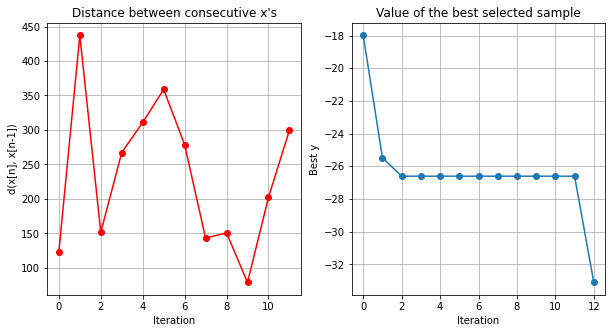

In [151]:
# 最適化履歴
myBopt.plot_convergence()

In [152]:
# 途中計算されたインプットとアウトプット
#print(myBopt.X)
print(type(myBopt.X))
print(myBopt.X.shape)
#print(myBopt.Y)
print(type(myBopt.Y))
print(myBopt.Y.shape)

<class 'numpy.ndarray'>
(13, 13)
<class 'numpy.ndarray'>
(13, 1)


In [60]:
#myBopt.model.model 